<a href="https://colab.research.google.com/github/gabrieladamasceno/Attacks_5G/blob/main/C%C3%B3digo_MLP_todo_junto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
from google.colab import drive
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Acessar dataset
drive.mount('/content/gdrive')

# Carregar o dataset
encoded = pd.read_csv("/content/gdrive/MyDrive/Datasets/Attacks/Encoded/Encoded.csv")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [24]:
pip install imbalanced-learn


In [25]:
!pip install --upgrade tensorflow
!pip install --upgrade keras

In [26]:
# Selecionar apenas colunas numéricas
numeric_cols = encoded.select_dtypes(include=['number']).columns

# Aplicar a suavização apenas nas colunas numéricas
for col in numeric_cols:
    encoded[col] = encoded[col].fillna(encoded[col].mean())

In [27]:
# columns with null values

columns_null = []
columns = encoded.columns
for column in columns:
    c = encoded[column].isnull().sum()
    if c != 0:
        print(column, 'has {} null values'.format(c))
        columns_null.append(column)

In [28]:
import psutil
import time
import numpy as np
import pandas as pd
import gc
import tensorflow as tf
import subprocess
import matplotlib.pyplot as plt
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import backend as K

# ===== Função para monitorar CPU e memória =====
def monitor_resource_usage():
    process = psutil.Process()
    memory_info = process.memory_info()
    cpu_percent = psutil.cpu_percent(interval=0.1)
    memory_usage_mb = memory_info.rss / (1024 * 1024)
    return cpu_percent, memory_usage_mb

def calcular_energia(cpu_usage, freq_ghz, tempo_exec_s, theta=1.0, z=1e-27):
    freq_hz = freq_ghz * 1e9
    carga = cpu_usage * theta * freq_hz
    energia_joules = z * (carga ** 3) * tempo_exec_s
    return energia_joules

# ===== Callback para monitoramento durante o treinamento =====
class ResourceMonitor(Callback):
    def on_train_begin(self, logs=None):
        self.cpu_usage = []
        self.memory_usage = []
        self.start_time = time.time()
        print("\n[Início do Treinamento]")

    def on_epoch_begin(self, epoch, logs=None):
        cpu, mem = monitor_resource_usage()
        self.cpu_usage.append(cpu)
        self.memory_usage.append(mem)
        print(f"\n[Época {epoch + 1} - Início] CPU: {cpu:.2f}%, Memória: {mem:.2f} MB")

    def on_epoch_end(self, epoch, logs=None):
        cpu, mem = monitor_resource_usage()
        self.cpu_usage.append(cpu)
        self.memory_usage.append(mem)
        print(f"[Época {epoch + 1} - Fim] CPU: {cpu:.2f}%, Memória: {mem:.2f} MB")

        # Limpeza de recursos
        gc.collect()
        K.clear_session()

    def on_train_end(self, logs=None):
        total_time = time.time() - self.start_time
        avg_cpu = np.mean(self.cpu_usage)
        avg_mem = np.mean(self.memory_usage)

        frequencia_cpu_ghz = 2.0  # Assuma 2.0 GHz se não souber a real

        # Cálculo de energia corrigido
        energia = calcular_energia(avg_cpu, frequencia_cpu_ghz, total_time)

        print("\n[Fim da Predição/Teste]")
        print(f"Tempo total: {total_time:.2f} segundos")
        print(f"Uso médio de CPU (Teste): {avg_cpu:.2f}%")
        print(f"Consumo médio de memória (Teste): {avg_mem:.2f} MB")
        print(f"Consumo estimado de energia: {energia:.6f} Joules")

        self._plot_usage()

    def _plot_usage(self):
        epochs = list(range(1, len(self.cpu_usage) + 1))

        plt.figure(figsize=(14, 5))

        # CPU
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.cpu_usage, marker='o', linestyle='-', color='tab:blue', label='CPU Usage')
        plt.xlabel("Época")
        plt.ylabel("Uso de CPU (%)")
        plt.title("Consumo de CPU (Train)")
        plt.legend()
        plt.grid(True)

        # Memória
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.memory_usage, marker='o', linestyle='-', color='tab:red', label='Memory Usage')
        plt.xlabel("Época")
        plt.ylabel("Memória (MB)")
        plt.title("Consumo de Memória (Train)")
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.savefig("resource_usage_train.png")
        plt.show()
        plt.clf()
        plt.close()

# ===== Monitoramento durante o teste/predição =====
def monitor_test_prediction(model, X_test):
    cpu_usage_test = []
    memory_usage_test = []

    print("\n[Início da Predição/Teste]")
    start_time = time.time()

    step_size = max(1, len(X_test) // 10)
    for i in range(0, len(X_test), step_size):
        end_i = min(i + step_size, len(X_test))
        monitor_cpu, monitor_mem = monitor_resource_usage()
        cpu_usage_test.append(monitor_cpu)
        memory_usage_test.append(monitor_mem)
        _ = model.predict(X_test[i:end_i], verbose=0)

    total_time = time.time() - start_time
    avg_cpu = np.mean(cpu_usage_test)
    avg_mem = np.mean(memory_usage_test)

    frequencia_cpu_ghz = 2.0  # Assuma 2.0 GHz se não souber a real

    # Cálculo de energia
    energia = calcular_energia(avg_cpu, frequencia_cpu_ghz, total_time)

    print("\n[Fim da Predição/Teste]")
    print(f"Tempo total: {total_time:.2f} segundos")
    print(f"Uso médio de CPU (Teste): {avg_cpu:.2f}%")
    print(f"Consumo médio de memória (Teste): {avg_mem:.2f} MB")
    print(f"Consumo estimado de energia: {energia:.6f} Joules")


    # Gráficos
    plt.figure(figsize=(14, 5))

    # CPU
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(cpu_usage_test) + 1), cpu_usage_test, marker='o', linestyle='-', color='tab:blue', label='CPU Usage (Test)')
    plt.xlabel("Bloco de Predição")
    plt.ylabel("Uso de CPU (%)")
    plt.title("Consumo de CPU (Test)")
    plt.legend()
    plt.grid(True)

    # Memória
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(memory_usage_test) + 1), memory_usage_test, marker='o', linestyle='-', color='tab:red', label='Memory Usage (Test)')
    plt.xlabel("Bloco de Predição")
    plt.ylabel("Memória (MB)")
    plt.title("Consumo de Memória (Test)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig("resource_usage_test.png")
    plt.show()
    plt.clf()
    plt.close()

resource_monitor = ResourceMonitor()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)


====== Zero-Day: ICMPFlood ======

[Início do Treinamento]

[Época 1 - Início] CPU: 0.10%, Memória: 5687.29 MB
[Época 1 - Fim] CPU: 1.00%, Memória: 4394.31 MB

[Época 2 - Início] CPU: 0.10%, Memória: 4394.33 MB
[Época 2 - Fim] CPU: 0.00%, Memória: 4429.27 MB

[Época 3 - Início] CPU: 0.10%, Memória: 4429.26 MB
[Época 3 - Fim] CPU: 0.10%, Memória: 4440.98 MB

[Época 4 - Início] CPU: 0.00%, Memória: 4440.98 MB
[Época 4 - Fim] CPU: 0.10%, Memória: 4451.87 MB

[Época 5 - Início] CPU: 0.00%, Memória: 4451.86 MB
[Época 5 - Fim] CPU: 0.00%, Memória: 4462.26 MB

[Época 6 - Início] CPU: 0.30%, Memória: 4462.25 MB
[Época 6 - Fim] CPU: 0.00%, Memória: 4472.19 MB

[Época 7 - Início] CPU: 1.80%, Memória: 4472.18 MB
[Época 7 - Fim] CPU: 0.10%, Memória: 4491.55 MB

[Época 8 - Início] CPU: 0.10%, Memória: 4491.55 MB
[Época 8 - Fim] CPU: 0.60%, Memória: 4502.43 MB

[Época 9 - Início] CPU: 0.00%, Memória: 4502.42 MB
[Época 9 - Fim] CPU: 1.00%, Memória: 4512.63 MB

[Época 10 - Início] CPU: 0.00%, Memória

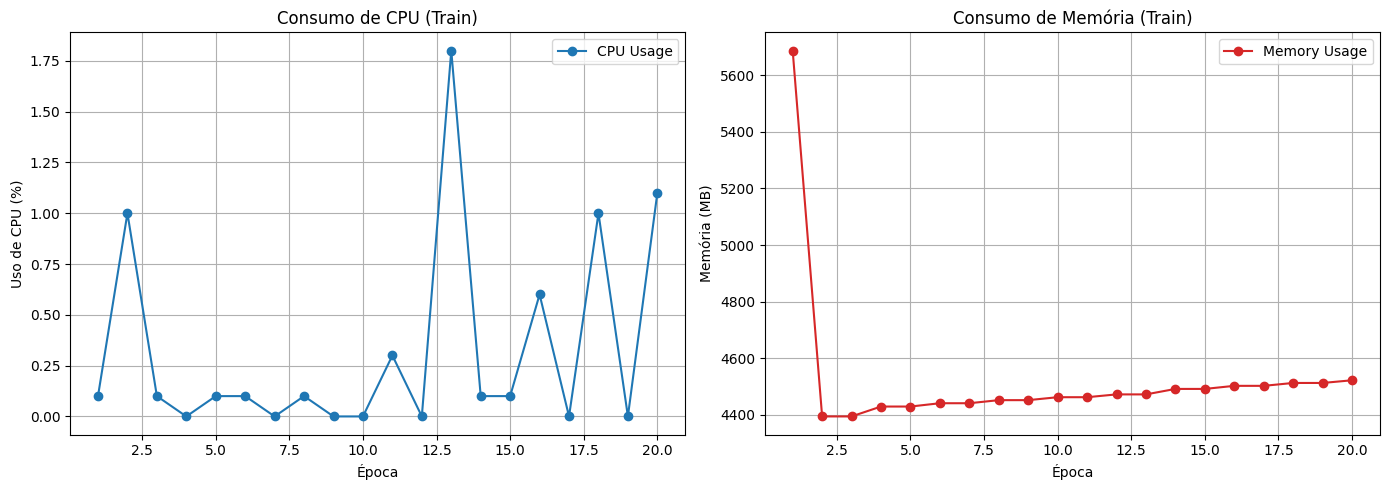

7600/7600 ━━━━━━━━━━━━━━━━━━━━ 6s 843us/step

[Início da Predição/Teste]

[Fim da Predição/Teste]
Tempo total: 10.64 segundos
Uso médio de CPU (Teste): 0.45%
Consumo médio de memória (Teste): 4556.65 MB
Consumo estimado de energia: 7.993170 Joules


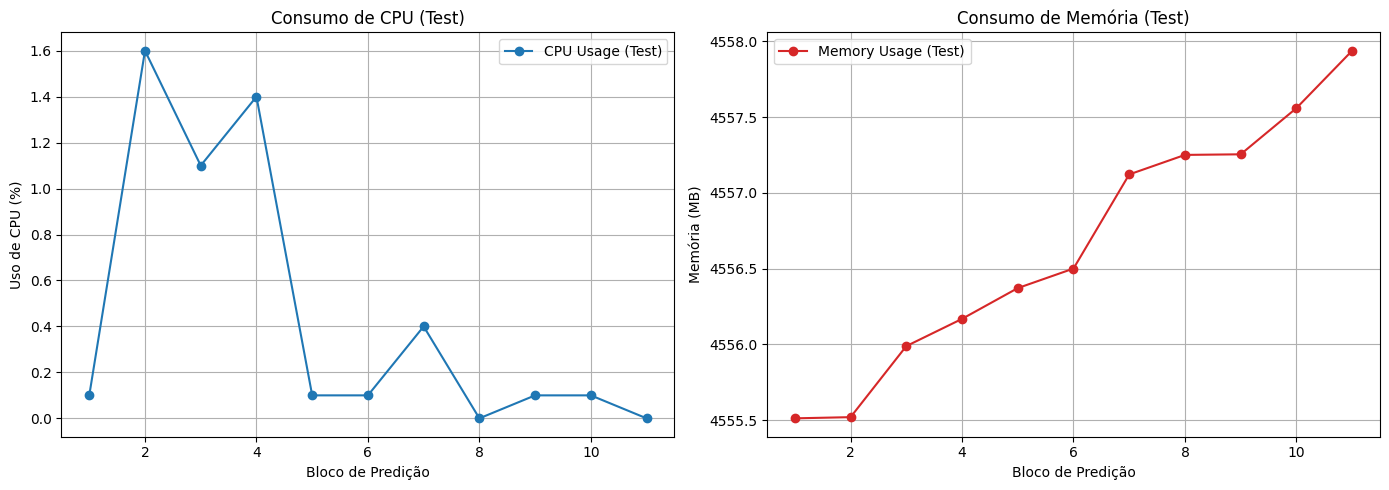

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

[Início da Predição/Teste]

[Fim da Predição/Teste]
Tempo total: 2.02 segundos
Uso médio de CPU (Teste): 0.16%
Consumo médio de memória (Teste): 4428.10 MB
Consumo estimado de energia: 0.070884 Joules


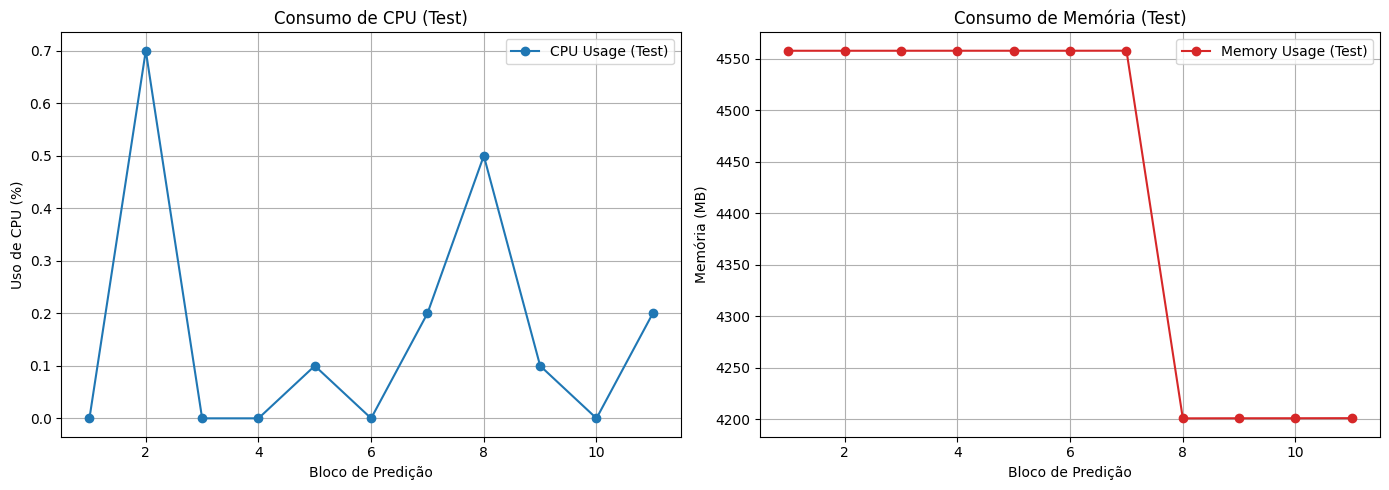


====== Zero-Day: UDPFlood ======

[Início do Treinamento]

[Época 1 - Início] CPU: 0.20%, Memória: 4847.37 MB
[Época 1 - Fim] CPU: 1.80%, Memória: 4240.02 MB

[Época 2 - Início] CPU: 1.50%, Memória: 4240.04 MB
[Época 2 - Fim] CPU: 0.20%, Memória: 4263.90 MB

[Época 3 - Início] CPU: 0.10%, Memória: 4263.89 MB
[Época 3 - Fim] CPU: 0.00%, Memória: 4274.96 MB

[Época 4 - Início] CPU: 0.10%, Memória: 4274.96 MB
[Época 4 - Fim] CPU: 0.10%, Memória: 4281.87 MB

[Época 5 - Início] CPU: 0.00%, Memória: 4281.86 MB
[Época 5 - Fim] CPU: 0.00%, Memória: 4289.29 MB

[Época 6 - Início] CPU: 0.30%, Memória: 4289.28 MB
[Época 6 - Fim] CPU: 1.40%, Memória: 4296.03 MB

[Época 7 - Início] CPU: 1.10%, Memória: 4296.02 MB
[Época 7 - Fim] CPU: 0.00%, Memória: 4304.98 MB

[Época 8 - Início] CPU: 0.10%, Memória: 4304.98 MB
[Época 8 - Fim] CPU: 0.10%, Memória: 4313.08 MB

[Época 9 - Início] CPU: 0.20%, Memória: 4313.32 MB
[Época 9 - Fim] CPU: 0.70%, Memória: 4322.86 MB

[Época 10 - Início] CPU: 0.10%, Memória:

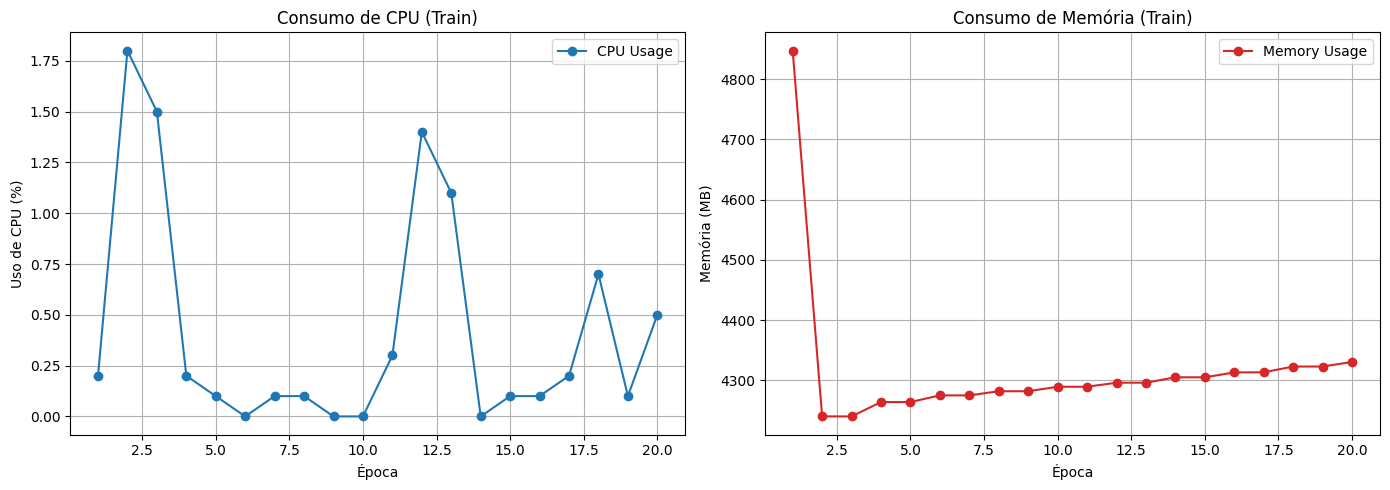

7600/7600 ━━━━━━━━━━━━━━━━━━━━ 6s 834us/step

[Início da Predição/Teste]

[Fim da Predição/Teste]
Tempo total: 11.06 segundos
Uso médio de CPU (Teste): 0.38%
Consumo médio de memória (Teste): 4212.19 MB
Consumo estimado de energia: 4.926306 Joules


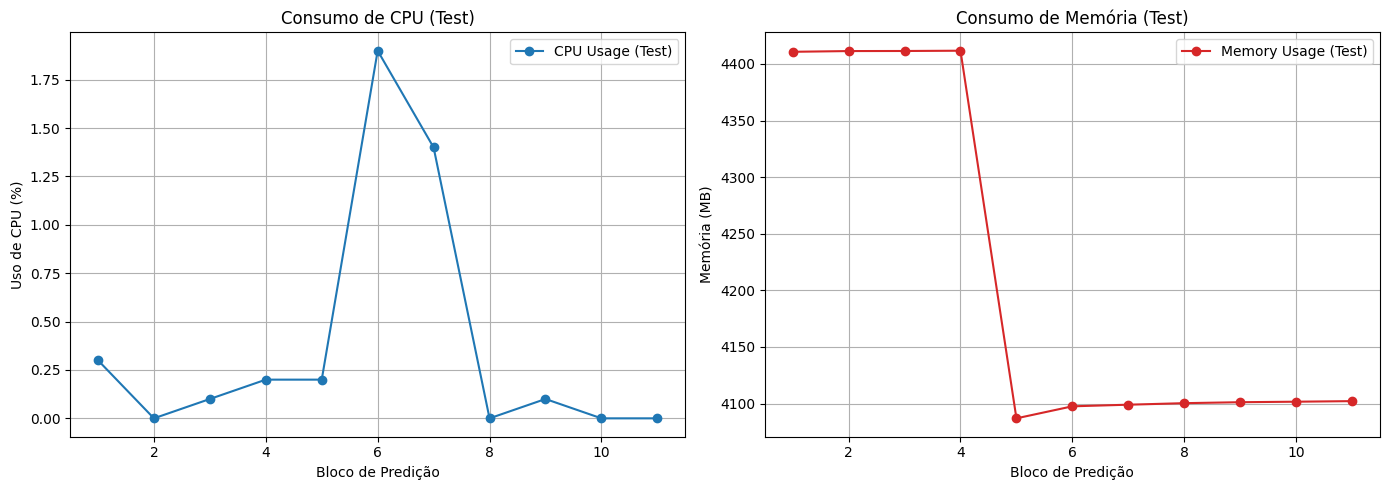

2857/2857 ━━━━━━━━━━━━━━━━━━━━ 2s 847us/step

[Início da Predição/Teste]

[Fim da Predição/Teste]
Tempo total: 5.40 segundos
Uso médio de CPU (Teste): 0.83%
Consumo médio de memória (Teste): 4140.51 MB
Consumo estimado de energia: 24.472414 Joules


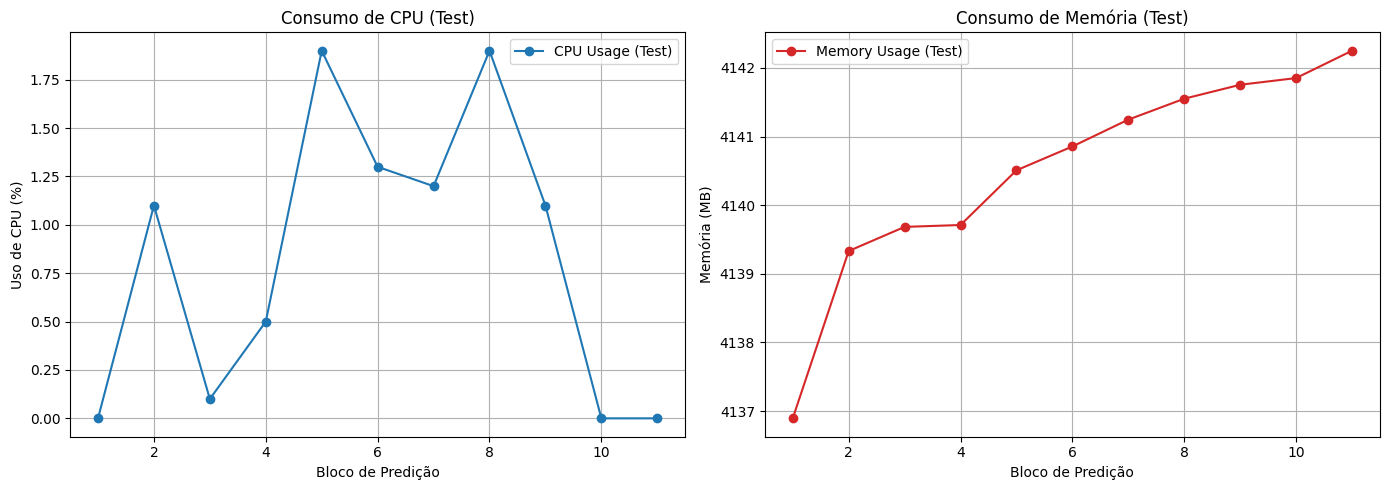


====== Zero-Day: SYNFlood ======

[Início do Treinamento]

[Época 1 - Início] CPU: 1.50%, Memória: 5079.24 MB
[Época 1 - Fim] CPU: 0.00%, Memória: 4565.54 MB

[Época 2 - Início] CPU: 0.50%, Memória: 4565.55 MB
[Época 2 - Fim] CPU: 0.10%, Memória: 4612.02 MB

[Época 3 - Início] CPU: 0.00%, Memória: 4612.01 MB
[Época 3 - Fim] CPU: 0.00%, Memória: 4623.14 MB

[Época 4 - Início] CPU: 0.20%, Memória: 4623.13 MB
[Época 4 - Fim] CPU: 1.40%, Memória: 4632.64 MB

[Época 5 - Início] CPU: 1.50%, Memória: 4632.63 MB
[Época 5 - Fim] CPU: 0.10%, Memória: 4638.04 MB

[Época 6 - Início] CPU: 1.00%, Memória: 4638.04 MB
[Época 6 - Fim] CPU: 0.00%, Memória: 4648.61 MB

[Época 7 - Início] CPU: 0.20%, Memória: 4648.61 MB
[Época 7 - Fim] CPU: 0.10%, Memória: 4657.48 MB

[Época 8 - Início] CPU: 0.90%, Memória: 4657.47 MB
[Época 8 - Fim] CPU: 1.00%, Memória: 4665.28 MB

[Época 9 - Início] CPU: 0.20%, Memória: 4665.27 MB
[Época 9 - Fim] CPU: 0.00%, Memória: 4673.95 MB

[Época 10 - Início] CPU: 0.00%, Memória:

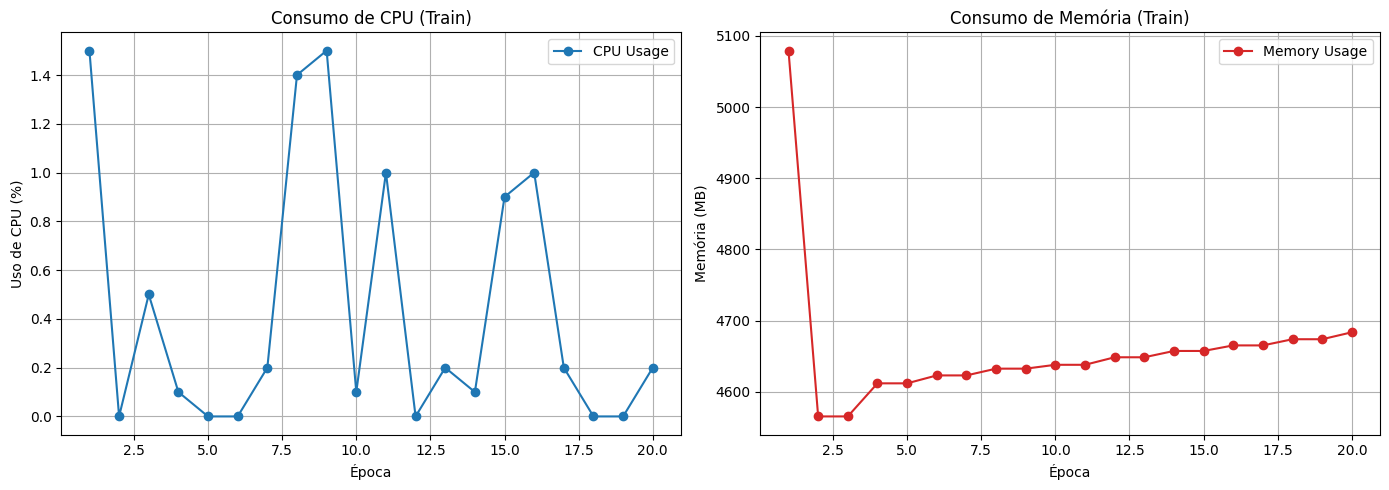

7600/7600 ━━━━━━━━━━━━━━━━━━━━ 6s 837us/step

[Início da Predição/Teste]

[Fim da Predição/Teste]
Tempo total: 10.83 segundos
Uso médio de CPU (Teste): 0.46%
Consumo médio de memória (Teste): 4757.38 MB
Consumo estimado de energia: 8.637555 Joules


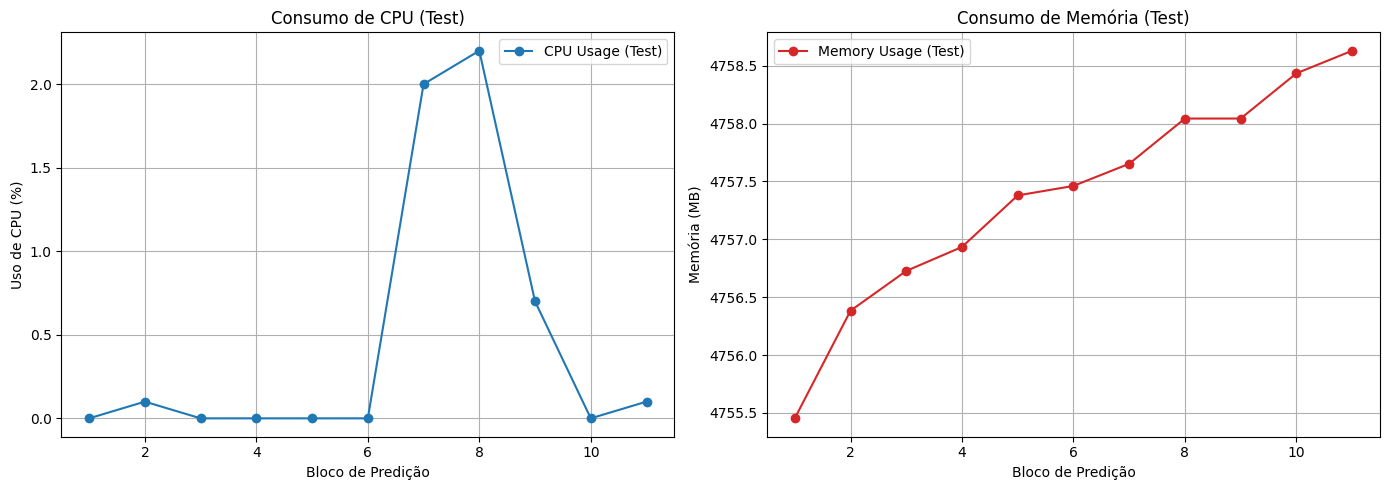

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

[Início da Predição/Teste]

[Fim da Predição/Teste]
Tempo total: 2.18 segundos
Uso médio de CPU (Teste): 0.15%
Consumo médio de memória (Teste): 4680.42 MB
Consumo estimado de energia: 0.064261 Joules


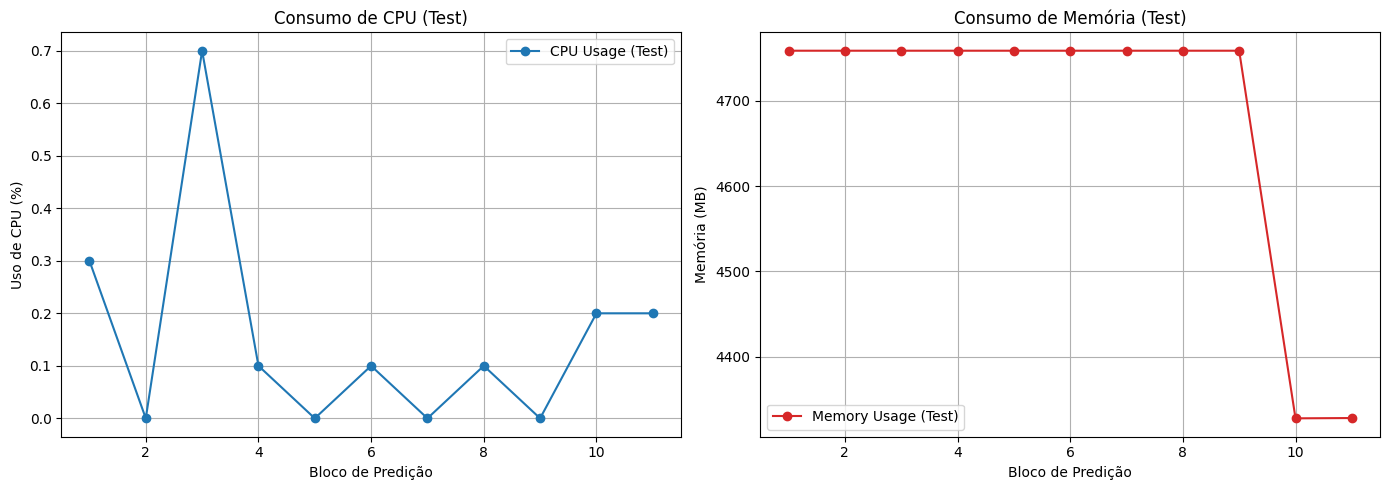

In [29]:
# ===== IMPORTS =====
import pandas as pd
import numpy as np
import time
import psutil
import gc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

# Configuração das features e rótulos
features = [
    'Seq', 'Offset', 'sTtl', 'tcp', 'AckDat', 'RST', 'INT', 'TcpRtt', 'icmp',
    'sMeanPktSz', 'FIN', 'sHops', 'Mean', 'dTtl', 'SrcBytes', 'TotBytes',
    'dMeanPktSz', 'Status', 'cs0', 'SrcWin', 'sTos', 'CON', 'REQ', 'Loss', 'Attack Type'
]

X = encoded[features]
y = encoded['Label']  # Coluna de rótulos

# Dividir antes de escolher zero-days
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Guardar Attack Type para separar os zero-days
X_train['Attack Type'] = encoded.loc[X_train.index, 'Attack Type']
X_test['Attack Type'] = encoded.loc[X_test.index, 'Attack Type']

# ===== CONFIGURAÇÕES =====
zero_day_attacks = ['ICMPFlood', 'UDPFlood', 'SYNFlood']  # Adapte para os ataques que você quiser testar
smote = SMOTE(random_state=42)
scaler = StandardScaler()
label_encoder = LabelEncoder()

resultados_zero_day = []

# ===== LOOP PRINCIPAL =====
resultados_zero_day = []

for ataque_zero_day in zero_day_attacks:
    print(f"\n====== Zero-Day: {ataque_zero_day} ======")

    # --- Separação dos dados ---
    train_indices = X_train[X_train['Attack Type'] != ataque_zero_day].index
    test_indices = X_test[X_test['Attack Type'] == ataque_zero_day].index

    X_train_clean = X_train.loc[train_indices].drop(columns=['Attack Type'])
    y_train_clean = y_train.loc[train_indices]
    X_test_zero_day = X_test.loc[test_indices].drop(columns=['Attack Type'])
    y_test_zero_day = y_test.loc[test_indices]
    X_test_full = X_test.drop(columns=['Attack Type'])
    y_test_full = y_test

    # --- Balanceamento ---
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_clean, y_train_clean)
    X_train_balanced = scaler.fit_transform(X_train_balanced)
    X_test_full_scaled = scaler.transform(X_test_full)
    X_test_zero_day_scaled = scaler.transform(X_test_zero_day)

    y_train_balanced = label_encoder.fit_transform(y_train_balanced)
    y_test_full_encoded = label_encoder.transform(y_test_full)
    y_test_zero_day_encoded = label_encoder.transform(y_test_zero_day)

    # --- Construção do Modelo ---
    model = Sequential()
    model.add(Input(shape=(X_train_balanced.shape[1],)))
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.4))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.4))
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    # --- TREINAMENTO COM MONITORAMENTO ---
    start_time = time.time()
    history = model.fit(
        X_train_balanced, y_train_balanced,
        validation_split=0.2,
        epochs=10,
        batch_size=128,
        callbacks=[early_stopping, reduce_lr, resource_monitor],
        verbose=0
    )

    # --- TESTE GERAL COM MONITORAMENTO ---
    start_time = time.time()
    y_pred_full = model.predict(X_test_full_scaled).round()
    monitor_test_prediction(model, X_test_full_scaled)
    acc_teste_full = accuracy_score(y_test_full_encoded, y_pred_full)
    f1_teste_full = f1_score(y_test_full_encoded, y_pred_full, zero_division=1)
    precision_full = precision_score(y_test_full_encoded, y_pred_full, zero_division=1)
    recall_full = recall_score(y_test_full_encoded, y_pred_full, zero_division=1)


    # --- TESTE ZERO-DAY COM MONITORAMENTO ---
    start_time = time.time()
    y_pred_zero_day = model.predict(X_test_zero_day_scaled).round()
    monitor_test_prediction(model, X_test_zero_day_scaled)
    acc_zero_day = accuracy_score(y_test_zero_day_encoded, y_pred_zero_day)
    f1_zero_day = f1_score(y_test_zero_day_encoded, y_pred_zero_day, zero_division=1)
    precision_zero = precision_score(y_test_zero_day_encoded, y_pred_zero_day, zero_division=1)
    recall_zero = recall_score(y_test_zero_day_encoded, y_pred_zero_day, zero_division=1)


    # --- Salvar resultados ---
    resultados_zero_day.append({
        'Ataque Zero-Day': ataque_zero_day,

        'Teste Geral - Acurácia': acc_teste_full,
        'Teste Geral - F1': f1_teste_full,
        'Teste Geral - Precision': precision_full,
        'Teste Geral - Recall': recall_full,

        'Zero-Day - Acurácia': acc_zero_day,
        'Zero-Day - F1': f1_zero_day,
        'ZeroDay - Precision': precision_zero,
        'ZeroDay - Recall': recall_zero
    })

    # --- Limpeza ---
    del model
    gc.collect()
    K.clear_session()

In [30]:
# ===== RESULTADOS FINAIS =====
df_resultados = pd.DataFrame(resultados_zero_day)
print(df_resultados)
df_resultados.to_csv('resultados_multi_zero_day_com_teste_geral.csv', index=False)

  Ataque Zero-Day  Teste Geral - Acurácia  Teste Geral - F1  \
0       ICMPFlood                0.998306          0.998601   
1        UDPFlood                0.623708          0.550158   
2        SYNFlood                0.995390          0.996183   

   Teste Geral - Precision  Teste Geral - Recall  Zero-Day - Acurácia  \
0                 0.999463              0.997741             0.000000   
1                 0.998608              0.379661             0.000000   
2                 0.999877              0.992516             0.679521   

   Zero-Day - F1  ZeroDay - Precision  ZeroDay - Recall  
0       0.000000                  1.0          0.000000  
1       0.000000                  1.0          0.000000  
2       0.809184                  1.0          0.679521  
